In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_absolute_error,mean_squared_error,r2_score, precision_score, recall_score,f1_score
from collections import defaultdict
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

!pip install catboost

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.4 MB/s eta 0:00:00


In [ ]:
df = pd.read_excel('drive/MyDrive/your_file_with_reviews.xlsx')

In [ ]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Review
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Let me tell you about my time with No and mini...
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,"And that's pretty much it! Overall, I'm really..."
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,But you know what? I wasn't too thrilled with ...
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,"And that's pretty much it! Overall, I'm really..."
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Here's my take on account management ease and ...


In [ ]:
unstructured_data = df[['customerID', 'Review','Churn']]
structured_data = df.drop(['customerID', 'Review'], axis=1)
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
                       'PaperlessBilling', 'PaymentMethod', 'Churn']

df_encoded_structred = pd.get_dummies(structured_data, columns=categorical_columns)
df_encoded_structred = df_encoded_structred.drop(['Churn_No'], axis=1)
print(df_encoded_structred)

      SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Female  \
0                 0       1           29.85         29.85           True   
1                 0      34           56.95       1889.50          False   
2                 0       2           53.85        108.15          False   
3                 0      45           42.30       1840.75          False   
4                 0       2           70.70        151.65           True   
...             ...     ...             ...           ...            ...   
7038              0      24           84.80       1990.50          False   
7039              0      72          103.20       7362.90           True   
7040              0      11           29.60        346.45           True   
7041              1       4           74.40        306.60          False   
7042              0      66          105.65       6844.50          False   

      gender_Male  Partner_No  Partner_Yes  Dependents_No  Dependents_Yes  \
0         

Visualization

Data Processing

In [ ]:
structured_train, structured_test = train_test_split(df_encoded_structred, test_size=0.2, random_state=42)
structured_train.head()
X_train = structured_train.drop(['Churn_Yes'], axis=1)
y_train = structured_train[['Churn_Yes']]
X_test = structured_test.drop(['Churn_Yes'], axis=1)
y_test = structured_test[['Churn_Yes']]

In [ ]:
from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.fit(X_train, y_train, verbose=1000)
y_pred_structred =model.predict(X_test)

Learning rate set to 0.021554
0:	learn: 0.6784910	total: 60.9ms	remaining: 1m
999:	learn: 0.2979224	total: 12s	remaining: 0us


In [ ]:
accuracy = accuracy_score(y_test, y_pred_structred)
precision = precision_score(y_test, y_pred_structred)
recall = recall_score(y_test, y_pred_structred)
f1 = f1_score(y_test, y_pred_structred)
conf_matrix = confusion_matrix(y_test, y_pred_structred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8026969481902059
Precision: 0.6610169491525424
Recall: 0.5227882037533512
F1-score: 0.5838323353293412
Confusion Matrix:
 [[936 100]
 [178 195]]


Unstructred Data

Create an inverted index

In [ ]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

inverted_index = defaultdict(list)

def preprocess_and_create_inverted_index(text, doc_id):
    tokens = re.findall(r'\b\w+\b', text.lower())
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    for token in tokens:
        inverted_index[token].append(doc_id)

for index, row in unstructured_data.iterrows():
    doc_id = row['customerID']
    review = row['Review']
    preprocess_and_create_inverted_index(review, doc_id)

for term, doc_ids in inverted_index.items():
    print(f"{term}: {doc_ids}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


let: ['7590-VHVEG', '6388-TABGU', '1680-VDCWW', '6467-CHFZW', '8865-TNMNX', '2954-PIBKO', '4667-QONEA', '3957-SQXML', '5919-TMRGD', '6180-YBIQI', '2876-GZYZC', '1131-QQZEB', '4648-YPBTM', '3376-BMGFE', '1744-JHKYS', '6168-YBYNP', '7018-WBJNK', '9142-KZXOP', '9408-SSNVZ', '1251-KRREG', '6614-FHDBO', '6158-HDPXZ', '2277-AXSDC', '4237-CLSMM', '3811-VBYBZ', '9076-AXYIK', '4104-PVRPS', '3780-DDGSE', '6227-HWPWX', '3552-CTCYF', '6778-YSNIH', '4134-BSXLX', '4109-CYRBD', '0750-EBAIU', '8067-NIOYM', '2817-NTQDO', '6103-LIANB', '4710-FDUIZ', '6522-YRBXD', '0719-SYFRB', '2077-DDHJK', '9574-BOSMD', '0887-HJGAR', '3276-HDUEG', '8262-COGGB', '2682-KEVRP', '2480-JZOSN', '2684-EIWEO', '1173-NOEYG', '6647-ZEDXT', '6683-VLCTZ', '2037-XJFUP', '0285-INHLN', '4678-DVQEO', '2202-OUTMO', '1450-GALXR', '4220-TINQT', '5275-PMFUT', '2732-ISEZX', '3523-BRGUW', '2123-AGEEN', '2267-FPIMA', '9734-YWGEX', '5285-MVEHD', '4694-PHWFW', '0454-OKRCT', '4378-BZYFP', '4581-LNWUM', '3354-OADJP', '9170-ARBTB', '4546-FOKWR', 

In [ ]:
churn_labels = dict(zip(unstructured_data['customerID'], unstructured_data['Churn']))

churn_yes_reviews = [doc_id for doc_id, churn_label in churn_labels.items() if churn_label == 'Yes']
filtered_inverted_index = {term: doc_ids for term, doc_ids in inverted_index.items() if any(doc_id in churn_yes_reviews for doc_id in doc_ids)}
term_frequencies = {term: len(doc_ids) for term, doc_ids in filtered_inverted_index.items()}

sorted_terms = sorted(term_frequencies.items(), key=lambda x: x[1], reverse=True)

top_n = 30
print(f"Top {top_n} most used words in reviews with churn labeled as 'Yes':")
for term, frequency in sorted_terms[:top_n]:
    print(f"{term}: {frequency} times")


Top 30 most used words in reviews with churn labeled as 'Yes':
servic: 8640 times
tri: 2444 times
know: 1869 times
thrill: 1869 times
decid: 1869 times
someth: 1869 times
els: 1869 times
experi: 1149 times
want: 1116 times
network: 1089 times
reliabl: 1089 times
promot: 1078 times
contract: 1077 times
term: 1077 times
devic: 1065 times
flexibl: 1054 times
account: 1053 times
manag: 1053 times
custom: 1052 times
qualiti: 1051 times
bill: 1035 times
outag: 992 times
offer: 960 times
visit: 898 times
place: 885 times
region: 882 times
area: 882 times
ye: 874 times
got: 824 times
happen: 802 times


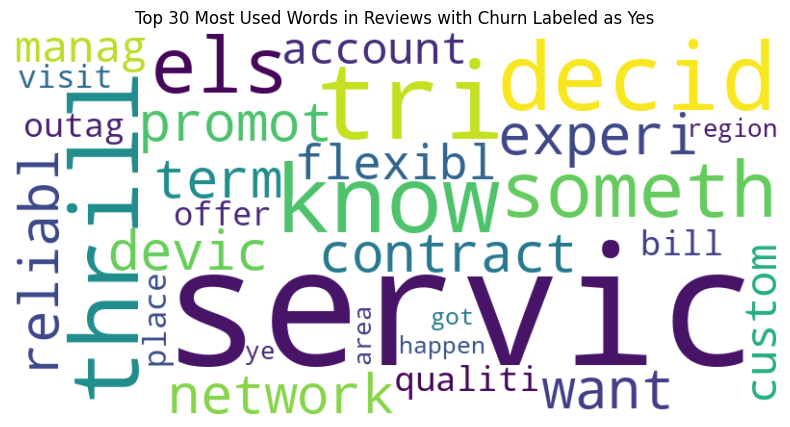

In [ ]:
top_n = 30
top_words = {term: frequency for term, frequency in sorted_terms[:top_n]}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"Top {top_n} Most Used Words in Reviews with Churn Labeled as Yes")
plt.show()


In [ ]:
unstructured_data

,customerID,Review,Churn
0,7590-VHVEG,Let me tell you about my time with No and mini...,No
1,5575-GNVDE,"And that's pretty much it! Overall, I'm really...",No
2,3668-QPYBK,But you know what? I wasn't too thrilled with ...,Yes
3,7795-CFOCW,"And that's pretty much it! Overall, I'm really...",No
4,9237-HQITU,Here's my take on account management ease and ...,Yes
...,...,...,...
7038,6840-RESVB,Let's dive into my experience with device vari...,No
7039,2234-XADUH,Wanted to share a quick review of clear billin...,No
7040,4801-JZAZL,I had such an interesting experience with flex...,No
7041,8361-LTMKD,But you know what? I wasn't too thrilled with ...,Yes


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalnum()]
    return tokens

df['Review'] = df['Review'].apply(preprocess_text)


In [ ]:
X_train_unstructured, X_test_unstructured, y_train_unstructured, y_test_unstructured = train_test_split(
    df['Review'], df['Churn'], test_size=0.2, random_state=42)


In [ ]:
train_documents = [TaggedDocument(words=words, tags=[i]) for i, words in enumerate(X_train_unstructured)]
d2v_model = Doc2Vec(vector_size=100, min_count=2, epochs=40)
d2v_model.build_vocab(train_documents)
d2v_model.train(train_documents, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

X_train_vectors = [d2v_model.infer_vector(words) for words in X_train_unstructured]
X_test_vectors = [d2v_model.infer_vector(words) for words in X_test_unstructured]


In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train_vectors, y_train_unstructured)

y_pred_sentiments = lr_model.predict(X_test_vectors)

In [ ]:
accuracy = accuracy_score(y_pred_sentiments,y_test_unstructured)
print("accuracy = ",accuracy)
precision = precision_score(y_pred_sentiments,y_test_unstructured,pos_label='Yes')
print("precision = ",precision)
f1score = f1_score(y_pred_sentiments,y_test_unstructured,pos_label='Yes')
print("f1_score = ",f1score)
confussionMatrix = confusion_matrix(y_pred_sentiments,y_test_unstructured)
print("Confussion Matrix =\n ",confussionMatrix)

accuracy =  0.9900638750887154
precision =  0.9758713136729222
f1_score =  0.9811320754716981
Confussion Matrix =
  [[1031    9]
 [   5  364]]


In [ ]:
# Calculate performance metrics for logistic regression model
lr_accuracy = accuracy_score(y_test_unstructured, y_pred_sentiments)
lr_precision = precision_score(y_test_unstructured, y_pred_sentiments, pos_label='Yes')
lr_recall = recall_score(y_test_unstructured, y_pred_sentiments, pos_label='Yes')
lr_f1_score = f1_score(y_test_unstructured, y_pred_sentiments, pos_label='Yes')
lr_confusion_matrix = confusion_matrix(y_test_unstructured, y_pred_sentiments)

# Calculate performance metrics for CatBoost model
cb_accuracy = accuracy_score(y_test, y_pred_structred)
cb_precision = precision_score(y_test, y_pred_structred)
cb_recall = recall_score(y_test, y_pred_structred)
cb_f1_score = f1_score(y_test, y_pred_structred)
cb_confusion_matrix = confusion_matrix(y_test, y_pred_structred)

# Create a DataFrame to display the performance metrics
performance_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Logistic Regression': [lr_accuracy, lr_precision, lr_recall, lr_f1_score],
    'CatBoost': [cb_accuracy, cb_precision, cb_recall, cb_f1_score]
})

# Display the performance metrics DataFrame
print(performance_metrics)

# Display the confusion matrices
print("Confusion Matrix for Logistic Regression:\n", lr_confusion_matrix)
print("Confusion Matrix for CatBoost:\n", cb_confusion_matrix)


      Metric  Logistic Regression  CatBoost
0   Accuracy             0.990064  0.802697
1  Precision             0.986450  0.661017
2     Recall             0.975871  0.522788
3   F1 Score             0.981132  0.583832
Confusion Matrix for Logistic Regression:
 [[1031    5]
 [   9  364]]
Confusion Matrix for CatBoost:
 [[936 100]
 [178 195]]


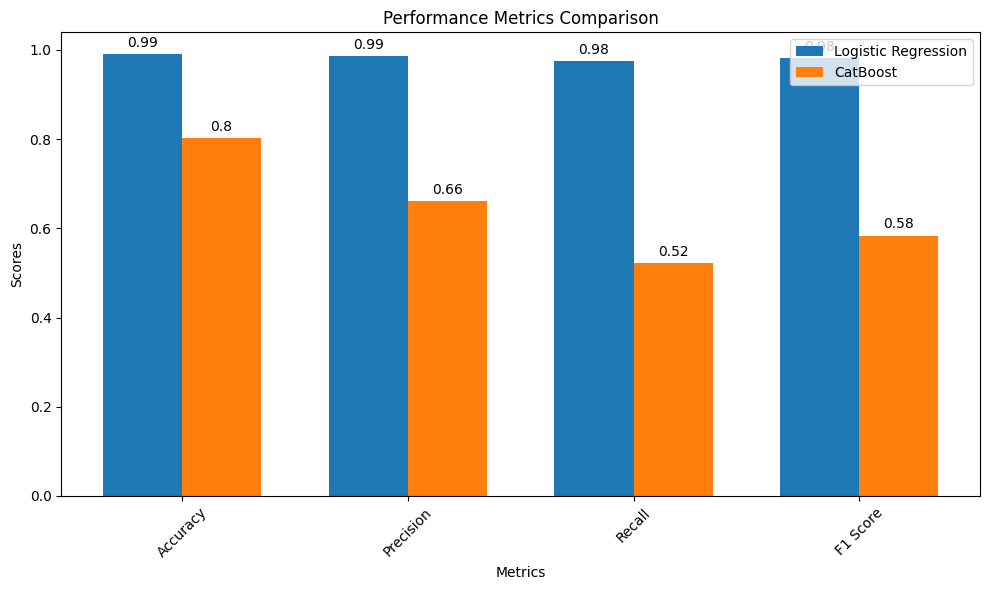

In [ ]:
import matplotlib.pyplot as plt

# Performance metrics data
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
lr_scores = [lr_accuracy, lr_precision, lr_recall, lr_f1_score]
cb_scores = [cb_accuracy, cb_precision, cb_recall, cb_f1_score]

# Plotting
x = range(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x, lr_scores, width, label='Logistic Regression')
rects2 = ax.bar([p + width for p in x], cb_scores, width, label='CatBoost')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics Comparison')
ax.set_xticks([p + 0.5 * width for p in x])
ax.set_xticklabels(metrics, rotation=45)  # Rotate x-axis labels
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()
